In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import digamma, logsumexp, gammaln

cmap = plt.get_cmap("tab10")

## データの生成

In [2]:
N = 500 # number of samples
D = 4 # nubmer of dimensions
K = 2 # number of clusters

# poisson distribution, observed data
a_model = 1.0 * np.ones((D,K))
b_model = 0.01 * np.ones(K)

# dirichlet distribution, phi
alpha_model = 10.0 * np.ones(K)

# dirichlet distribution, A
beta_model = 50.0 * np.eye(K) + 1.0 * np.ones((K,K))

In [3]:
lam_true = np.zeros((D,K))
for k in range(K):
    lam_true[:,k] = np.random.gamma(a_model[:,k], scale=1/b_model[k])
phi_true = np.random.dirichlet(alpha=alpha_model)
A_true = np.zeros((K,K))
for i in range(K):
    A_true[:,i] = np.random.dirichlet(alpha=beta_model[:,i])

S_true = np.zeros((K,N))
for n in range(N):
    if n == 0:
        S_true[:,n] = np.random.multinomial(n=1, pvals=phi_true)
    else:
        s = np.argmax(S_true[:,n-1])
        S_true[:,n] = np.random.multinomial(n=1, pvals=A_true[:,s])

X = np.zeros((D,N))
for n in range(N):
    s = np.argmax(S_true[:,n])
    for d in range(D):
        X[d,n] = np.random.poisson(lam=lam_true[d,s])

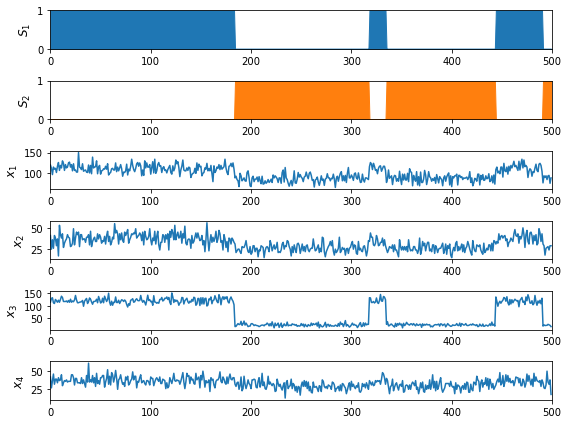

In [4]:
plt.figure(figsize=(8,1*K+1*D))
for k in range(K):
    plt.subplot(K+D,1,k+1)
    plt.fill_between(np.arange(N), S_true[k,:], np.zeros(N), color=cmap(k))
    plt.xlim(0,500)
    plt.ylim(0,1)
    plt.ylabel(r'$S_{%i}$'%(k+1), fontsize=12)

for d in range(D):
    plt.subplot(K+D,1,K+d+1)
    plt.plot(np.arange(N), X[d,:])
    plt.xlim(0,500)
    plt.ylabel(r'$x_{%i}$'%(d+1), fontsize=12)
plt.tight_layout()

## アルゴリズム

In [5]:
def update_Z(X, Z, parameters):
    (K, N) = Z.shape
    #D = len(X)
    a_post, b_post, alpha_post, beta_post = parameters
    
    ln_lkh = np.zeros((K,N))
    for k in range(K):
        ln_lam = digamma(a_post[:,k]) - np.log(b_post[k])
        lam = a_post[:,k] / b_post[k]
        for n in range(N):
            ln_lkh[k,n] = np.sum(X[:,n] * ln_lam - lam)
    
    expt_ln_phi = digamma(alpha_post) - digamma(np.sum(alpha_post))
    
    expt_ln_A = np.zeros((K,K))
    for i in range(K):
        expt_ln_A[:,i] = digamma(beta_post[:,i]) - digamma(np.sum(beta_post[:,i]))
    
    ln_expt_Z = np.log(Z+1e-10)
    # n = 0
    ln_expt_Z[:,0] = ln_lkh[:,0] + expt_ln_phi + np.dot(expt_ln_A.T, np.exp(ln_expt_Z[:,1]))
    ln_expt_Z[:,0] -= logsumexp(ln_expt_Z[:,0])
    
    # 0 < n < N-1
    for n in range(1,N-1):
        ln_expt_Z[:,n] = ln_lkh[:,n] + np.dot(expt_ln_A, np.exp(ln_expt_Z[:,n-1])) + np.dot(expt_ln_A.T, np.exp(ln_expt_Z[:,n+1]))
        ln_expt_Z[:,n] -= logsumexp(ln_expt_Z[:,n])
    
    # n = N-1
    ln_expt_Z[:,N-1] = ln_lkh[:,N-1] + np.dot(expt_ln_A, np.exp(ln_expt_Z[:,N-2]))
    ln_expt_Z[:,N-1] -= logsumexp(ln_expt_Z[:,N-1])
    
    expt_Z = np.exp(ln_expt_Z)
    
    expt_ZZ = np.zeros((K,K,N))
    for n in range(N-1):
        for j in range(K):
            for i in range(K):
                expt_ZZ[j,i,n+1] = expt_Z[j,n+1] * expt_Z[i,n]
    
    return expt_Z, expt_ZZ

In [6]:
def update_parameters(prior, X, Z, ZZ):
    (K, N) = Z.shape
    D = len(X)
    a_pri, b_pri, alpha_pri, beta_pri = prior
    sum_Z = np.sum(Z, 1)
    sum_ZZ = np.sum(ZZ, 2)
    
    alpha_post = Z[:,0] + alpha_pri
    beta_post = sum_ZZ + beta_pri
    
    a_post = np.zeros((D,K))
    b_post = np.zeros(K)
    ZX = np.dot(X, Z.T) # (D,N) * (K,N).T = (D,K)
    for k in range(K):
        a_post[:,k] = ZX[:,k] + a_pri[:,k]
        b_post[k] = sum_Z[k] + b_pri[k]
    
    return a_post, b_post, alpha_post, beta_post

In [7]:
def calc_elbo(X, Z, ZZ, prior, posterior):
    (K, N) = Z.shape
    D = len(X)
    a_pri, b_pri, alpha_pri, beta_pri = prior
    a_post, b_post, alpha_post, beta_post = posterior
    
    expt_ln_lam = np.zeros((D,K))
    expt_lam = np.zeros((D,K))
    for k in range(K):
        expt_ln_lam[:,k] = digamma(a_post[:,k]) - np.log(b_post[k])
        expt_lam[:,k] = a_post[:,k] / b_post[k]
    
    expt_ln_lkh = np.zeros((K,N))
    for k in range(K):
        for n in range(N):
            expt_ln_lkh[k,n] = Z[k,n] * np.sum(X[:,n] * expt_ln_lam[:,k] - expt_lam[:,k] - gammaln(X[:,n]+1))
    
    expt_ln_phi = digamma(alpha_post) - digamma(np.sum(alpha_post))
    expt_ln_A = np.zeros((K,K))
    for i in range(K):
        expt_ln_A[:,i] = digamma(beta_post[:,i]) - digamma(np.sum(beta_post[:,i]))
    
    expt_ln_ps = np.zeros((1,N))
    for n in range(N):
        if n == 0:
            expt_ln_ps[:,n] = np.dot(Z[:,0], expt_ln_phi)
        else:
            expt_ln_ps[:,n] = np.sum( ZZ[:,:,n] * expt_ln_A)
    
    expt_ln_qs = np.sum( Z * np.log(Z + 1e-10))
    
    kl_lam = 0.0
    for k in range(K):
        kl_lam += np.sum( (a_post[:,k] - a_pri[:,k]) * expt_ln_lam[:,k] - (b_post[k] - b_pri[k]) * expt_lam[:,k] 
                         + a_post[:,k] * np.log(b_post[k]) - a_pri[:,k] * np.log(b_pri[k]) 
                         - gammaln(a_post[:,k]) + gammaln(a_pri[:,k]) )
    
    kl_phi = ( np.dot(alpha_post- alpha_pri, expt_ln_phi) 
              + gammaln(np.sum(alpha_post)) - np.sum(gammaln(alpha_post)) 
              - gammaln(np.sum(alpha_pri)) + np.sum(gammaln(alpha_pri)) )
    
    kl_A = ( np.sum((beta_post - beta_pri) * expt_ln_A) 
            + np.sum(gammaln(np.sum(beta_post, 0))) - np.sum(gammaln(beta_post)) 
            - np.sum(gammaln(np.sum(beta_pri, 0))) + np.sum(gammaln(beta_pri)) )
    
    VB = np.sum(expt_ln_lkh) + np.sum(expt_ln_ps) - expt_ln_qs - kl_lam - kl_phi - kl_A
    return VB

## モデルおよび事前分布の設定

In [8]:
# model
(D, N) = X.shape
K = 2

# poisson dist.
a_init = 1.0 * np.ones((D,K))
b_init = 0.01 * np.ones(K)

# dirichlet dist
alpha_init = 10.0 * np.ones(K)

# dirichlet dist.
beta_init = 100.0 * np.eye(K) + 1.0 * np.ones((K,K))

## パラメータの初期化

In [9]:
# initialisation
lam = np.zeros((D,K))
for k in range(K):
    lam[:,k] = np.random.gamma(a_init[:,k], scale=1/b_init[k])
phi = np.random.dirichlet(alpha=alpha_init)
A = np.zeros((K,K))
for i in range(K):
    A[:,i] = np.random.dirichlet(alpha=beta_init[:,i])

S = np.zeros((K,N))
for n in range(N):
    S[:,n] = np.random.dirichlet(np.ones(K)/K, 1)

SS = np.zeros((K,K,N))
for n in range(N-1):
    for j in range(K):
        for i in range(K):
            SS[j,i,n+1] = S[j,n+1] * S[i,n]

## 学習

In [10]:
expt_Z = np.copy(S)
expt_ZZ = np.copy(SS)
tmp_a, tmp_b, tmp_alpha, tmp_beta = update_parameters([a_init, b_init, alpha_init, beta_init], X, expt_Z, expt_ZZ)

max_iter = 100
elbo = np.zeros(max_iter)

for i in range(max_iter):
    expt_Z, expt_ZZ = update_Z(X, expt_Z, [tmp_a, tmp_b, tmp_alpha, tmp_beta])
    tmp_a, tmp_b, tmp_alpha, tmp_beta = update_parameters([a_init, b_init, alpha_init, beta_init], X, expt_Z, expt_ZZ)
    elbo[i] = calc_elbo(X, expt_Z, expt_ZZ, [a_init, b_init, alpha_init, beta_init], [tmp_a, tmp_b, tmp_alpha, tmp_beta])

## 学習結果

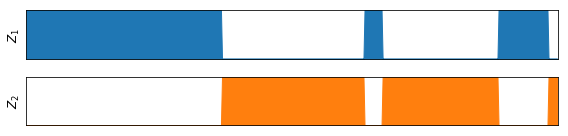

In [11]:
plt.figure(figsize=(8,1*K))
for k in range(K):
    plt.subplot(K,1,k+1, xticks=[], yticks=[])
    plt.fill_between(np.arange(N), expt_Z[k,:], np.zeros(N), color=cmap(k))
    plt.xlim(0,500)
    plt.ylim(0,1)
    plt.ylabel(r'$Z_{%i}$'%(k+1), fontsize=12)
plt.tight_layout()

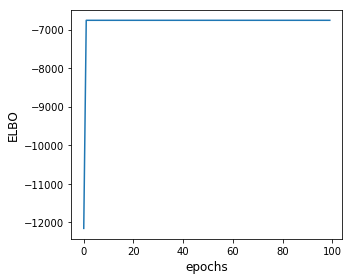

In [12]:
plt.figure(figsize=(5,4))
plt.plot(np.arange(max_iter), elbo)
plt.xlabel('epochs', fontsize=12)
plt.ylabel('ELBO', fontsize=12)
plt.tight_layout()